# Diffusivity - General - Batch

This notebook processes the traj_50 data in batch.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import trackpy as tp
from skimage import io
from corrLib import readdata, xy_bin
from xiaolei.chain.tracking import gauss1
from scipy.optimize import curve_fit
from myImageLib import bestcolor, dirrec
from utils import *
import dufte
plt.style.use('default')
from scipy.signal import savgol_filter
from IPython.display import clear_output

## Sparce trajectory analysis

In [3]:
folder = r'C:\Users\liuzy\Documents\Data\DE\11032021\Analysis\01'
traj = pd.read_csv(os.path.join(folder, 'traj_50.csv'))
t = traj.assign(frame=traj.index, particle=0)
msd = tp.msd(t, mpp=0.33, fps=1, max_lagtime=100)

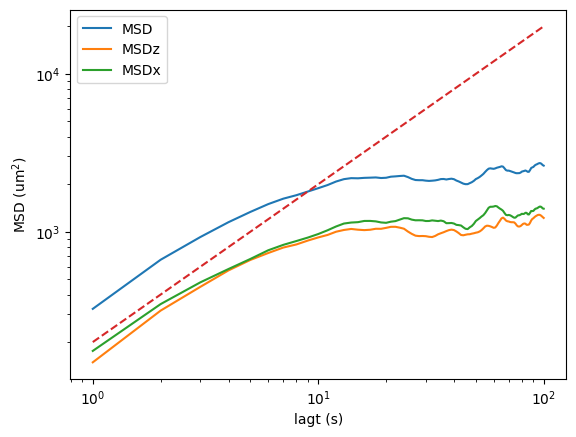

In [7]:
plt.plot(msd.lagt, msd.msd, label='MSD')
plt.plot(msd.lagt, msd['<x^2>'], label='MSDz')
plt.plot(msd.lagt, msd['<y^2>'], label='MSDx')
plt.loglog()
plt.plot(msd.lagt, 200*msd.lagt, ls='--')
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')
plt.legend()

**Comments:** the MSD obtained from 600 points look ok. 600 more can potentially complete the short time regime. 

In [74]:
traj = pd.read_csv(os.path.join(folder, 'traj_1.csv'))
t = traj.assign(frame=traj.index, particle=0)

In [34]:
msd = tp.msd(t, fps=50, mpp=0.33, max_lagtime=3000)

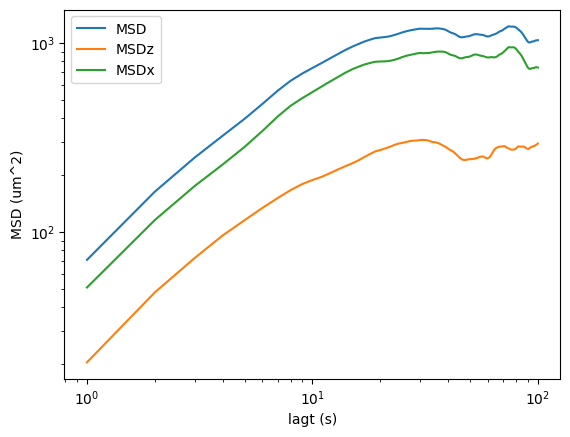

In [8]:
plt.plot(msd.lagt, msd.msd, label='MSD')
plt.plot(msd.lagt, msd['<x^2>'], label='MSDz')
plt.plot(msd.lagt, msd['<y^2>'], label='MSDx')
plt.loglog()
# plt.plot(msd.lagt, 200*msd.lagt, ls='--')
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um^2)')
plt.legend()
# plt.xlim([0, 1])

In [75]:
t['x'] = savgol_filter(t['x'], 5, 3)
t['y'] = savgol_filter(t['y'], 5, 3)

In [76]:
msd = tp.msd(t, fps=50, mpp=0.33, max_lagtime=3000)

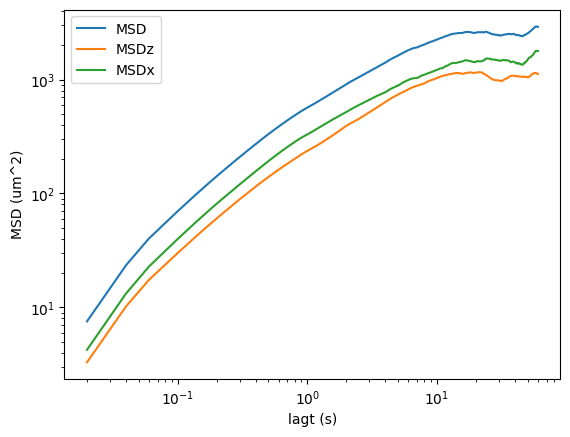

In [77]:
plt.plot(msd.lagt, msd.msd, label='MSD')
plt.plot(msd.lagt, msd['<x^2>'], label='MSDz')
plt.plot(msd.lagt, msd['<y^2>'], label='MSDx')
plt.loglog()
# plt.plot(msd.lagt, 200*msd.lagt, ls='--')
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um^2)')
plt.legend()
# plt.xlim([0, 1])

In [70]:
# tracking quality
image_folder = r'C:\Users\liuzy\Documents\Data\DE\11032021\01'
l = readdata(image_folder, 'tif')
save_folder = os.path.join(folder, 'tracking_quality')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
for num, i in l[25::50].iterrows():
    img = io.imread(i.Dir)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.imshow(img, cmap='gray')
    ax.scatter(t.x[num], t.y[num])
#     plt.pause(.5)
    clear_output(wait=True)
    fig.savefig(os.path.join(save_folder, i.Name+'.jpg'), dpi=50)
    plt.close()    

## traj -> MSD

In [28]:
def traj_to_msd(traj_dir, fps=50, mpp=0.33):
    """Read traj file and calculate MSD, save MSD to file in the same folder as traj file.
    Name the MSD file by replacing "traj" in traj file name with "MSD". 
    For example, the MSD file for traj file "traj_50_11022021_01.csv" will be renamed to "MSD_50_11022021_01.csv".
    Args:
    traj_dir -- directory of traj file (.csv containing x, y, frame, particle
    fps -- frames per second, this value is usually in log file
    mpp -- microns per pixel, this value is usually in log file
    Returns:
    msd"""
    traj = pd.read_csv(traj_dir)
    if "particle" not in traj:
        traj = traj.assign(particle=0)
    if "frame" not in traj:
        traj = traj.assign(frame=traj.index)
    msd = tp.msd(traj, fps=fps, mpp=mpp, max_lagtime=int(len(traj)/10))
    msd.to_csv(traj_dir.replace("traj", "MSD"), index=False)
    return msd

In [25]:
test_dir = "~/Documents/GitHub/DE/Data/Real_data/traj_50_10272021_03.csv"
msd = traj_to_msd(test_dir)

In [17]:
# load log 
data_folder = "/Users/zhoulin/Documents/GitHub/DE/Data/Real_data/"
log = pd.read_csv(os.path.join(data_folder, "OD50-75.csv"))
log.head()

,Unnamed: 0,#,OD,D,d,MMP,FPS,Easy to analyze?,Plane,Comment,date,Quality
0,3,3,70.0,127.5,12.3,0.33,50.0,No,XZ,NaN,10272021,NaN
1,11,11,65.0,48.9,17.0,0.11,50.0,Yes,XZ,NaN,10262021,NaN
2,12,12,65.0,74.0,15.4,0.11,50.0,Yes,XZ,small inner drop,10262021,NaN
3,13,13,65.0,63.4,30.9,0.11,50.0,Yes,XZ,large inner drop,10262021,NaN
4,15,15,70.0,100.0,25.7,0.11,50.0,Yes,XZ,outer size increasing,10262021,NaN


In [29]:
for num, i in log.iterrows():
    date_str = "{:08d}".format(int(i.date))
    num_str = "{:02d}".format(int(i["#"]))
    traj_dir = os.path.join(data_folder, "traj_50_{}_{}.csv".format(date_str, num_str))
    video_FPS = i.FPS
    interval = 50
    fps = interval / i.FPS
    msd = traj_to_msd(traj_dir, fps=fps, mpp=i.MMP)

### Plot MSD with different color scheme

In [35]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 8)

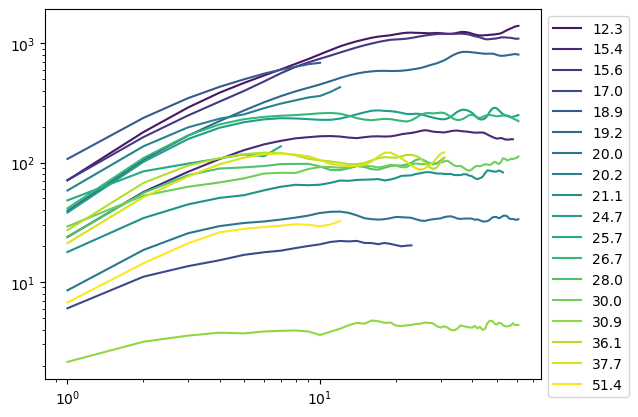

In [45]:
log.sort_values("d", inplace=True)
log.reset_index(drop=True, inplace=True)
viridis = cm.get_cmap('viridis', len(log))
for num, i in log[1:].iterrows():
    date_str = "{:08d}".format(int(i.date))
    num_str = "{:02d}".format(int(i["#"]))
    msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
    msd = pd.read_csv(msd_dir)
    plt.plot(msd.lagt, msd.msd, color=viridis(num), label=i.d)
plt.loglog()
plt.legend(bbox_to_anchor=(1, 1))

In [43]:
log

,Unnamed: 0,#,OD,D,d,MMP,FPS,Easy to analyze?,Plane,Comment,date,Quality
0,20,20,65.0,128.7,12.1,0.33,50.0,No,XZ,"small inner, .will be impossible to track/ cut...",11022021,NaN
1,3,3,70.0,127.5,12.3,0.33,50.0,No,XZ,NaN,10272021,NaN
2,12,12,65.0,74.0,15.4,0.11,50.0,Yes,XZ,small inner drop,10262021,NaN
3,4,4,66.0,132.6,15.6,0.33,50.0,No,XZ,NaN,11032021,NaN
4,11,11,65.0,48.9,17.0,0.11,50.0,Yes,XZ,NaN,10262021,NaN
5,16,16,70.0,120.7,18.9,0.11,50.0,No,XZ,"outer size increasing, too many drops in a sam...",10262021,NaN
6,6,6,66.0,195.1,19.2,0.33,50.0,No,XZ,NaN,11032021,NaN
7,5,5,51.0,140.0,20.0,0.33,50.0,NaN,XZ,"very large outer drop 140/20, have to use 20x ...",11022021,NaN
8,9,9,57.0,159.1,20.2,0.33,50.0,No,XZ,Inner droplet pops out,11032021,NaN
9,8,8,57.0,72.5,21.1,0.33,50.0,Yes,XZ,Inner droplet pops out,11032021,NaN
